### Imports

In [26]:
from src import (
    MultiFeatureLanguageModel, NgramLanguageModel, 
    load_language_samples,
    evaluate_model, create_confusion_matrix, save_results, setup_logger,
)

### Divide between test and train data

In [27]:
setup_logger()

total_data = load_language_samples('data/raw', limit=500)
train_data = {lang: docs[:400] for lang, docs in total_data.items()}
test_data = {lang: docs[400:] for lang, docs in total_data.items()}

train_text = sum(train_data.values(), [])
train_langs = sum([[lang] * len(docs) for lang, docs in train_data.items()], [])

test_langs = sum([[lang] * len(docs) for lang, docs in test_data.items()], [])

### Train the models

In [28]:
ngram_model = NgramLanguageModel(n_range=(3,3))
ngram_model.train(train_text, train_langs)

multi_feature_model = MultiFeatureLanguageModel(pos_tags=True)
multi_feature_model.train(train_text, train_langs)
multi_feature_model.save_model('models/multi_feature_model.pkl')
# multi_feature_model.load_model('models/multi_feature_model.pkl')

### N-grams model results

In [29]:
predict = ngram_model.predict
results_hindi = list(map(predict, test_data['hindi']))
results_marathi = list(map(predict, test_data['marathi']))

y_true = test_langs
y_pred = results_marathi + results_hindi

confusion_matrix = create_confusion_matrix(y_true, y_pred)
results = evaluate_model(y_true, y_pred)

save_results(results, 'results/500/ngram_language_model.json')
print(confusion_matrix)

[[100   0]
 [ 10  90]]


### Linguistic features based classifier results

In [ ]:
# run for various combinations of features
import itertools

features = ['special_char_ratio', 'char_freq', 'word_length'
            'vowel_consonant_ratio', 'pos_tags', 'tf-idf',
            'morphological_patterns', 'character_class_distribution']

chosen_feature_combs = []

for n in range(1, len(features) + 1):
    for feature_comb in itertools.combinations(features, n):
        predict = multi_feature_model.predict
        results_hindi = list(map(lambda text: predict(text, feature_comb), test_data['hindi']))
        results_marathi = list(map(lambda text: predict(text, feature_comb), test_data['marathi']))

        y_pred = results_marathi + results_hindi
        results = evaluate_model(y_true, y_pred)
        chosen_feature_combs.append(feature_comb)
        save_results(results, f'results/500/multi_feature_model_features-{'-'.join(feature_comb)}.json')

/home/norman_singh/documents/iiit/2-1/CL2/language-identification-analysis/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/norman_singh/documents/iiit/2-1/CL2/language-identification-analysis/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/norman_singh/documents/iiit/2-1/CL2/language-identification-analysis/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in label

### Plotting results of chosen features

/tmp/ipykernel_1007/2203786607.py:50: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


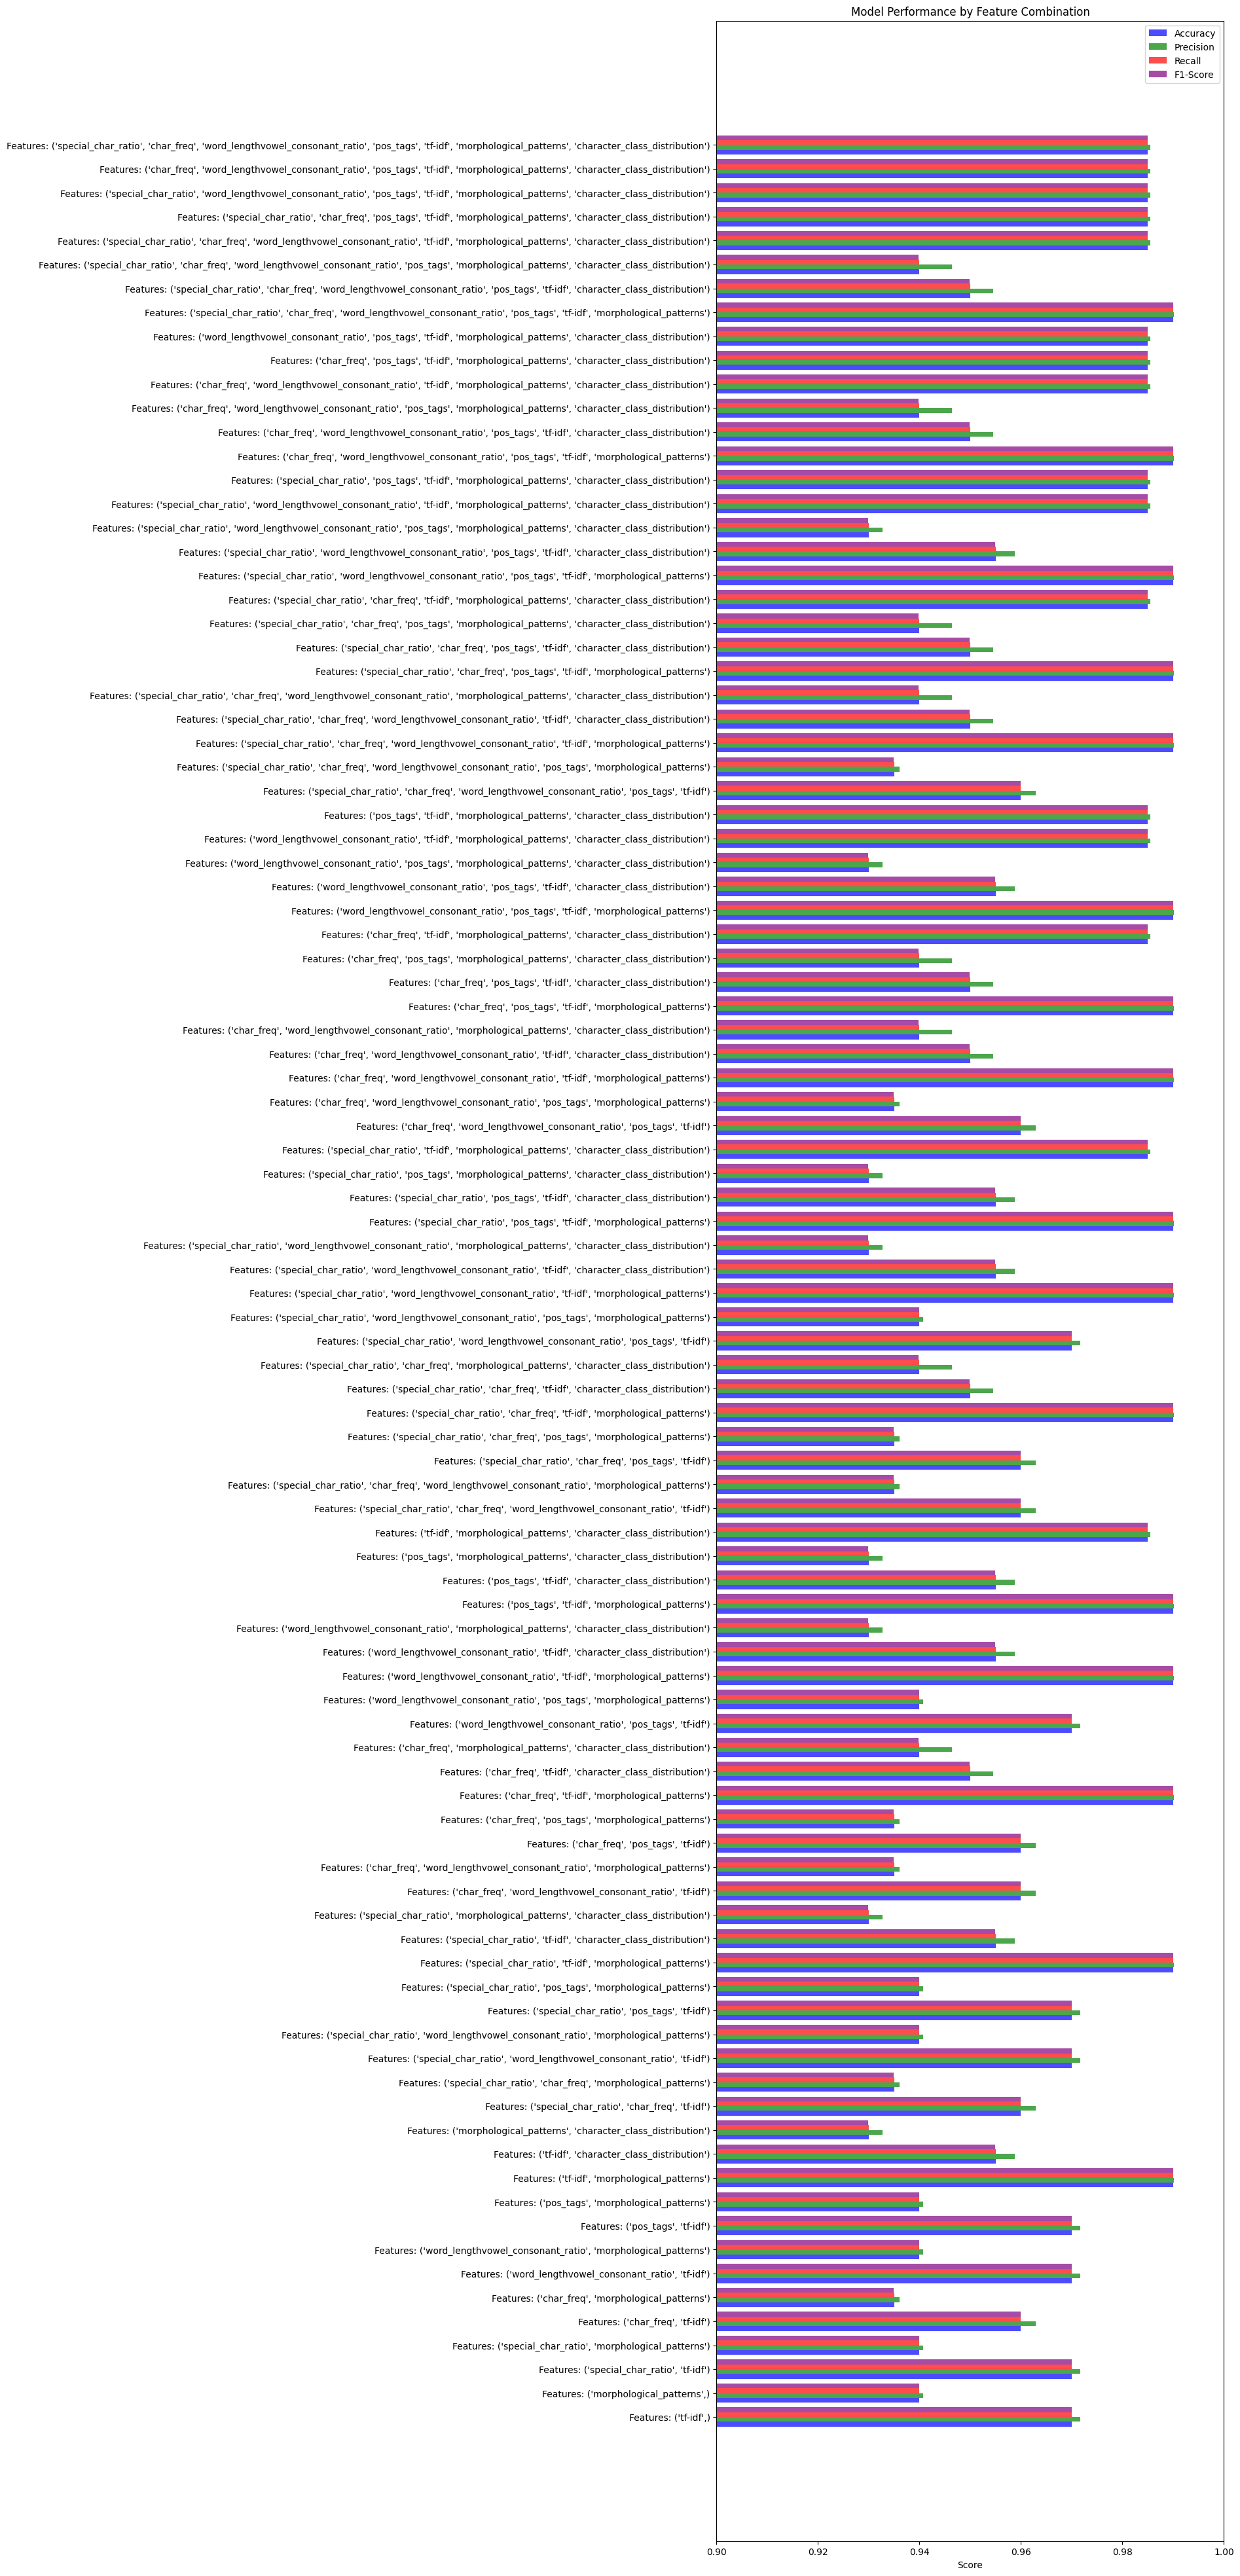

In [43]:
import matplotlib.pyplot as plt
import json

results = []
for feature_comb in chosen_feature_combs:
    with open(f'results/500/multi_feature_model_features-{'-'.join(feature_comb)}.json') as f:
        result = json.load(f)
        brk = 0
        for key in result:
            if result[key] < 0.9: brk=1
            # else: print(key, result[key])
        if brk: continue
        result['features'] = feature_comb
        results.append(result)

# group results by feature combination
feature_comb_scores = {}
for result in results:
    if tuple(result['features']) not in feature_comb_scores:
        feature_comb_scores[tuple(result['features'])] = [
            result['accuracy'], 
            result['precision'], 
            result['recall'], 
            result['f1_score']
        ]

# plot
feature_combs = list(feature_comb_scores.keys())
scores = list(feature_comb_scores.values())

fig, ax = plt.subplots(figsize=(10, len(feature_combs)*0.5 + 2))
bar_height = 0.2
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
colors = ['blue', 'green', 'red', 'purple']

for i, (feature_comb, score_set) in enumerate(feature_comb_scores.items()):
    for j, (score, metric, color) in enumerate(zip(score_set, metrics, colors)):
        ax.barh(i + j*bar_height, score, height=bar_height, 
                label=f'{metric}', color=color, alpha=0.7)

ax.set_yticks([i + bar_height*1.5 for i in range(len(feature_combs))])
ax.set_yticklabels([f'Features: {feature_comb}' for feature_comb in feature_combs])

ax.set_xlim(0.9, 1)
ax.set_xlabel('Score')
ax.set_title('Model Performance by Feature Combination')

ax.legend(metrics, loc='upper right')

plt.tight_layout()
plt.show()

### Categorising the results on the basis of all metrics

In [36]:
# categpries: [enum]
# - any metric below 0.9    [0]
# - all metrics over 0.9    [1]
# - all metrics over 0.95   [2]
# - all metrics over 0.98   [3]
# - all metrics over 0.99   [4]
# - all metrics over 0.995  [5]
# - all metrics over 0.998  [6]

!echo '{"0":[], "1":[], "2":[], "3":[], "4":[], "5":[], "6":[]}' > results/500/categories.json

for combination in chosen_feature_combs:
    with open(f'results/500/multi_feature_model_features-{'-'.join(combination)}.json') as f:
        result = json.load(f)
        enum = 6
        for metric in result:
            if result[metric] < 0.9:
                new_enum = 0
            elif result[metric] < 0.95:
                new_enum = 1
            elif result[metric] < 0.98:
                new_enum = 2
            elif result[metric] < 0.99:
                new_enum = 3
            elif result[metric] < 0.995:
                new_enum = 4
            elif result[metric] < 0.998:
                new_enum = 5
            else:
                new_enum = 6
            enum = min(enum, new_enum)
        with open('results/500/categories.json') as f:
            old = json.load(f)
        with open('results/500/categories.json', 'w') as f:
            old[str(enum)].append(combination)
            json.dump(old, f)

### 1-gram based model for sanity check (should give the same results as character frequency based model)

In [37]:
onegram_model = NgramLanguageModel(n_range=(1,1))
onegram_model.train(train_text, train_langs)

predict = onegram_model.predict
results_hindi = list(map(predict, test_data['hindi']))
results_marathi = list(map(predict, test_data['marathi']))

y_true = test_langs
y_pred = results_marathi + results_hindi

print(evaluate_model(y_true, y_pred))

{'accuracy': 0.995, 'precision': np.float64(0.9950495049504952), 'recall': np.float64(0.995), 'f1_score': np.float64(0.9949998749968749)}


### Token count and character count of training data

In [38]:
print('Hindi:')
hindi_text = ' '.join(train_data["hindi"])
print(f'\tTokens: {len(hindi_text.split())}')
print(f'\tCharacters: {len(hindi_text) - len(train_data["hindi"]) + 1}')

print('Marathi:')
marathi_text = ' '.join(train_data["marathi"])
print(f'\tTokens: {len(marathi_text.split())}')
print(f'\tCharacters: {len(marathi_text) - len(train_data["marathi"]) + 1}')

Hindi:
	Tokens: 306121
	Characters: 1578819
Marathi:
	Tokens: 238518
	Characters: 1413559
